# Anomaly Detection Techniques
https://www.kaggle.com/questions-and-answers/61779

Anomalies can be broadly categorized as:
### Point anomalies:
A single instance of data is anomalous if it's too far off from the rest. For example: Detecting credit card fraud based on "total spend."

### Contextual anomalies:
The abnormality is context specific. This type of anomaly is common in time-series data. For example: Spending more on heating during winter is normal, but may be odd otherwise.

### Collective anomalies:
A set of data instances collectively helps in detecting anomalies. For example: Someone is trying to copy data form a remote machine to a local host unexpectedly, an anomaly that would be flagged as a potential cyber attack.

Anomaly detection is similar to — but not entirely the same as — noise removal and novelty detection.

**Novelty detection** is concerned with identifying an unobserved pattern in new observations not included in training data like a sudden interest in a new channel on YouTube during Christmas, for instance.

**Noise removal** is the process of removing noise from an otherwise meaningful signal.

## Anomaly Detection Techniques

### Simple Statistical Methods
The simplest approach to identifying irregularities in data is to flag the data points that deviate from common statistical properties of a distribution, including mean, median, mode, and quantiles. Let's say the definition of an anomalous data point is one that deviates by a certain standard deviation from the mean. Traversing mean over time-series data isn't exactly trivial, as it's not static. You would need a rolling window to compute the average across the data points. Technically, this is called a rolling average or a moving average, and it's intended to smooth short-term fluctuations and highlight long-term ones. Mathematically, an n-period simple moving average can also be defined as a "low pass filter."

#### Challenges with Simple Statistical Methods
* The low pass filter allows you to identify anomalies in simple use cases, but there are certain situations where this technique won't work. Here are a few:

* The data contains noise which might be similar to abnormal behavior, because the boundary between normal and abnormal behavior is often not precise.

* The definition of abnormal or normal may frequently change, as malicious adversaries constantly adapt themselves. Therefore, the threshold based on moving average may not always apply.

* The pattern is based on seasonality. This involves more sophisticated methods, such as decomposing the data into multiple trends in order to identify the change in seasonality.

#### Machine Learning-Based Approaches
Below is a brief overview of popular machine learning-based techniques for anomaly detection.

##### Density-Based Anomaly Detection
Density-based anomaly detection is based on the k-nearest neighbors algorithm.

**Assumption**: Normal data points occur around a dense neighborhood and abnormalities are far away.

The nearest set of data points are evaluated using a score, which could be Eucledian distance or a similar measure dependent on the type of the data (categorical or numerical). They could be broadly classified into two algorithms:

* **K-nearest neighbor**: k-NN is a simple, non-parametric lazy learning technique used to classify data based on similarities in distance metrics such as Eucledian, Manhattan, Minkowski, or Hamming distance.

* **Relative density of data**: This is better known as local outlier factor (LOF). This concept is based on a distance metric called reachability distance.

##### Clustering-Based Anomaly Detection
Clustering is one of the most popular concepts in the domain of unsupervised learning.

**Assumption**: Data points that are similar tend to belong to similar groups or clusters, as determined by their distance from local centroids.

K-means is a widely used clustering algorithm. It creates 'k' similar clusters of data points. Data instances that fall outside of these groups could potentially be marked as anomalies.

##### Support Vector Machine-Based Anomaly Detection
A support vector machine is another effective technique for detecting anomalies. A SVM is typically associated with supervised learning, but there are extensions (OneClassCVM, for instance) that can be used to identify anomalies as an unsupervised problems (in which training data are not labeled). The algorithm learns a soft boundary in order to cluster the normal data instances using the training set, and then, using the testing instance, it tunes itself to identify the abnormalities that fall outside the learned region. Depending on the use case, the output of an anomaly detector could be numeric scalar values for filtering on domain-specific thresholds or textual labels (such as binary/multi labels).

In this jupyter notebook we are going to take the credit card fraud detection as the case study for understanding this concept in detail using the following Anomaly Detection Techniques

The dataset can be downloaded from https://www.kaggle.com/mlg-ulb/creditcardfraud

# Unsupervised Learning with Auto-Encoders

Ref: https://hackernoon.com/latent-space-visualization-deep-learning-bits-2-bd09a46920df <br>
Ref: https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html 


The idea is quite simple:
* The bottleneck architecture of the autoencoder in neural networks, forces the model to learn a condensed representation in order to reproduce the original input.
* By feeding the encoder onlynon-fraudulent transaction data, the encoder model learns the characteristics of these non-fraudulent transactions and can identify it with high fidelity.
* Now that the model can detect non-fraudulent transactions, the remainder transactions fall into the fraudulent category.Thus the auto-encoder will have trouble reproducing it with its learned weights, and the subsequent reconstruction loss will be high.
* Anything above a specific loss (treshold) will be flagged as anomalous and thus labeled as fraud.

# Preprocessing



In [1]:
## Import Libraries & set Random Seeds
# read & manipulate data
import pandas as pd 
import numpy as np
import tensorflow as tf 


# visualisations
import matplotlib.pyplot as plt
import seaborn as sns

# misc
import random as rn

# load the dataset
df = pd.read_csv('creditcard.csv')

# manual parameters
RANDOM_SEED = 1
TRAINING_SAMPLE = 200000
VALIDATE_SIZE = 0.2

# setting random seeds for libraries to ensure reproducibility
np.random.seed(RANDOM_SEED)
tf.random.set_seed(42)
rn.seed(RANDOM_SEED)

In [2]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Renaming columns

In [3]:
# let's quickly convert the columns to lower case and rename the Class column 
# so as to not cause syntax errors
df.columns = map(str.lower, df.columns)
df.rename(columns={'class': 'label'}, inplace=True)

# print first 5 rows to get an initial impression of the data we're dealing with
df.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,label
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
#EDA
# data overview of the df
print ('Rows     : ', df.shape[0])
print ('Columns  : ', df.shape[1])
print ('\nFeatures : ',df.columns.tolist())
print ('\nMissing values :  ', df.isnull().sum().values.sum())
print ('\nMissing values percentage:  ',df.isnull().sum().values.sum()/df.shape[0])
print ('\nUnique values :  \n', df.nunique())
print ('\nThe number of duplicate rows is:', df.duplicated().value_counts())
#Check for duplicates
print ('The number of duplicated rows is:', df.duplicated().sum())

Rows     :  284807
Columns  :  31

Features :  ['time', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20', 'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'amount', 'label']

Missing values :   0

Missing values percentage:   0.0

Unique values :  
 time      124592
v1        275663
v2        275663
v3        275663
v4        275663
v5        275663
v6        275663
v7        275663
v8        275663
v9        275663
v10       275663
v11       275663
v12       275663
v13       275663
v14       275663
v15       275663
v16       275663
v17       275663
v18       275663
v19       275663
v20       275663
v21       275663
v22       275663
v23       275663
v24       275663
v25       275663
v26       275663
v27       275663
v28       275663
amount     32767
label          2
dtype: int64

The number of duplicate rows is: False    283726
True       1081
dtype: int64
The number of duplicated rows is: 1081


0    284315
1       492
Name: label, dtype: int64

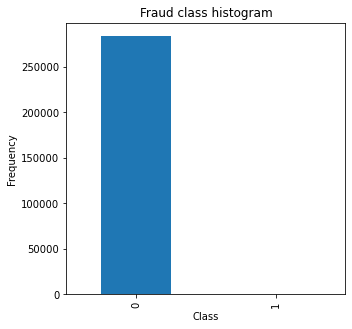

In [5]:
plt.figure(figsize=(5,5))
pd.value_counts(df['label']).plot.bar()
plt.title('Fraud class histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
df['label'].value_counts()

The dataset is free from missing values and duplicated fields.It can be used as such for data modeling.

In [6]:
pd.value_counts(df['label'])

0    284315
1       492
Name: label, dtype: int64

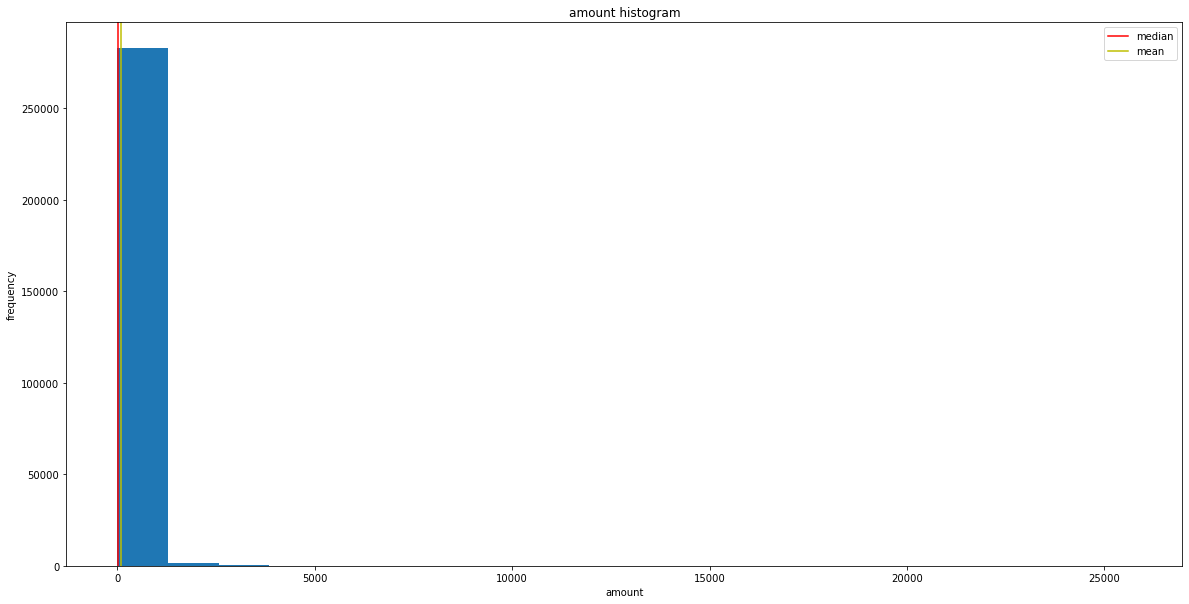

In [7]:
plt.figure(figsize=(20,10))
plt.hist(df['amount'], bins=20)
plt.xlabel('amount')
plt.ylabel('frequency')
plt.title('amount histogram')
plt.axvline(df['amount'].median(), label='median', c='r')
plt.axvline(df['amount'].mean(), label='mean', c='y')
plt.legend()
plt.show()

### Calculated field: log10(amount)

Turn the amount feature into a normally distributed log equivalent.

In [8]:
# add a negligible amount to avoid taking the log of 0
df['log10_amount'] = np.log10(df.amount + 0.00001)

In [9]:
# keep the label field at the back
df = df[
    [col for col in df if col not in ['label', 'log10_amount']] + 
    ['log10_amount', 'label']
]

### Visualising clusters with t-SNE
*t-Distributed Stochastic Neighbor Embedding (t-SNE)*

From the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html): <br>
**t-SNE is a dimensionality reduction technique used for visualisations** of complex datasets.
It **maps clusters in high-dimensional data** to **a two- or three dimensional plane** so we can get an idea of how easy it will be to **discriminate between classes**.
It does this by trying to keep the distance between data points in lower dimensions proportional to the probability that these data points are neighbours in the higher dimensions.

## Undersampling the non-fraud
To keep the computation time low, let's feed t-SNE only a small subsample (undersampling the clean transactions).

In [10]:
# manual parameter 
RATIO_TO_FRAUD = 10

# dropping redundant columns
df = df.drop(['time', 'amount'], axis=1)

# splitting by class
fraud = df[df.label == 1]
clean = df[df.label == 0]

# undersample clean transactions
clean_undersampled = clean.sample(
    int(len(fraud) * RATIO_TO_FRAUD),
    random_state=RANDOM_SEED
)

# concatenate with fraud transactions into a single dataframe
visualisation_initial = pd.concat([fraud, clean_undersampled])
column_names = list(visualisation_initial.drop('label', axis=1).columns)

# isolate features from labels 
features, labels = visualisation_initial.drop('label', axis=1).values, \
                   visualisation_initial.label.values

In [11]:
print(f"""The non-fraud dataset has been undersampled from {len(clean):,} to {len(clean_undersampled):,}.
This represents a ratio of {RATIO_TO_FRAUD}:1 to fraud.""")

The non-fraud dataset has been undersampled from 284,315 to 4,920.
This represents a ratio of 10:1 to fraud.


### t-SNE Output

In [12]:

from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

def tsne_scatter(features, labels, dimensions=2, save_as='graph.png'):
    if dimensions not in (2, 3):
        raise ValueError('tsne_scatter can only plot in 2d or 3d.Make sure the "dimensions" argument is in (2, 3)')

    # t-SNE dimensionality reduction
    features_embedded = TSNE(n_components=dimensions, random_state=RANDOM_SEED).fit_transform(features)
    
    # initialising the plot
    fig, ax = plt.subplots(figsize=(8,8))
    
    # counting dimensions
    if dimensions == 3: ax = fig.add_subplot(111, projection='3d')

    # plotting data
    ax.scatter(
        *zip(*features_embedded[np.where(labels==1)]),
        marker='o',
        color='r',
        s=2,
        alpha=0.7,
        label='Fraud'
    )
    ax.scatter(
        *zip(*features_embedded[np.where(labels==0)]),
        marker='o',
        color='g',
        s=2,
        alpha=0.3,
        label='Clean'
    )

    # storing it to be displayed later
    plt.legend(loc='best')
    plt.savefig(save_as);
    plt.show;

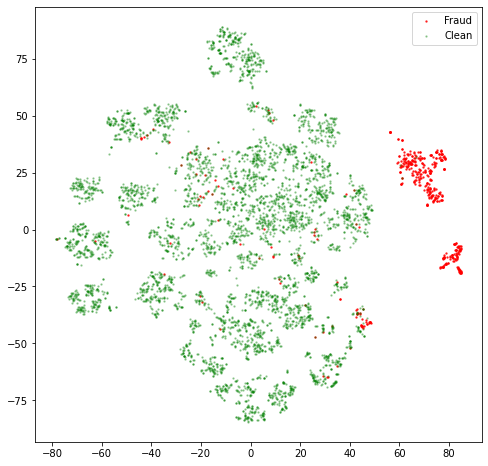

In [13]:
tsne_scatter(features, labels, dimensions=2, save_as='tsne_initial_2d.png')

Some clusters are apparent, but a minority of fraud transactions remains unclustered, hidden in between non-fraud transactions.

### Train/Validate/Test split
Our auto-encoder will only train on transactions that were normal. What's left over will be combined with the fraud set to form our test sample.


1. Training: only non-fraud
    * Split into:
        1. Actual training of our autoencoder
        2. Validation of the neural network's ability to generalize
2. Testing : mix of fraud and non-fraud
    * Treated like new data
    * Attempt to locate outliers
        1. Compute reconstruction loss
        2. Apply threshold

In [14]:
print(f"""Shape of the datasets:
    clean (rows, cols) = {clean.shape}
    fraud (rows, cols) = {fraud.shape}""")

Shape of the datasets:
    clean (rows, cols) = (284315, 30)
    fraud (rows, cols) = (492, 30)


In [15]:
# shuffle our training set
clean = clean.sample(frac=1).reset_index(drop=True)

# training set: exlusively non-fraud transactions
X_train = clean.iloc[:TRAINING_SAMPLE].drop('label', axis=1)

# testing  set: the remaining non-fraud + all the fraud 
X_test = clean.iloc[TRAINING_SAMPLE:].append(fraud).sample(frac=1)

In [16]:
print(f"""Our testing set is composed as follows:

{X_test.label.value_counts()}""")

Our testing set is composed as follows:

0    84315
1      492
Name: label, dtype: int64


In [17]:
from sklearn.model_selection import train_test_split

# train // validate - no labels since they're all clean anyway
X_train, X_validate = train_test_split(X_train, 
                                       test_size=VALIDATE_SIZE, 
                                       random_state=RANDOM_SEED)

# manually splitting the labels from the test df
X_test, y_test = X_test.drop('label', axis=1).values, X_test.label.values

In [18]:
#Summary
print(f"""Shape of the datasets:
    training (rows, cols) = {X_train.shape}
    validate (rows, cols) = {X_validate.shape}
    holdout  (rows, cols) = {X_test.shape}""")

Shape of the datasets:
    training (rows, cols) = (160000, 29)
    validate (rows, cols) = (40000, 29)
    holdout  (rows, cols) = (84807, 29)


## Normalising & Standardising
Data which is normally distributed can help stochastic gradient descent converge more effectively. 

At what point in the data processing do we apply standardisation/normalisation?
ref(An excellent answer was provided on StackOverflow.https://stackoverflow.com/questions/49444262/normalize-data-before-or-after-split-of-training-and-testing-data?answertab=active#tab-top)

You first need to split the data into training and test set (validation set could be useful too).

Don't forget that testing data points represent real-world data. Feature normalization (or data standardization) of the explanatory (or predictor) variables is a technique used to center and normalise the data by subtracting the mean and dividing by the variance. If you take the mean and variance of the whole dataset you'll be introducing future information into the training explanatory variables (i.e. the mean and variance).

Therefore, you should perform feature normalisation over the training data. Then perform normalisation on testing instances as well, but this time using the mean and variance of training explanatory variables. In this way, we can test and evaluate whether our model can generalize well to new, unseen data points.

[Answer by Giorgos Myrianthous]

### Building our pipeline

In [19]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

# configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

### Fitting the pipeline

In [20]:
# get normalization parameters by fitting to the training data
pipeline.fit(X_train);

### Applying transformations with acquired parameters

In [21]:
# transform the training and validation data with these parameters
X_train_transformed = pipeline.transform(X_train)
X_validate_transformed = pipeline.transform(X_validate)

### Before & After

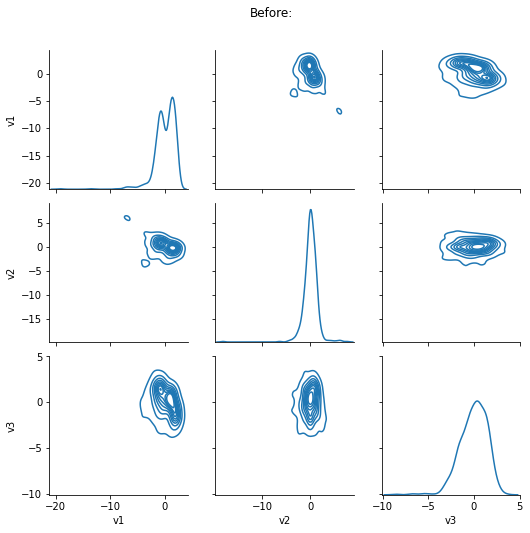

In [22]:
g = sns.PairGrid(X_train.iloc[:,:3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Before:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);

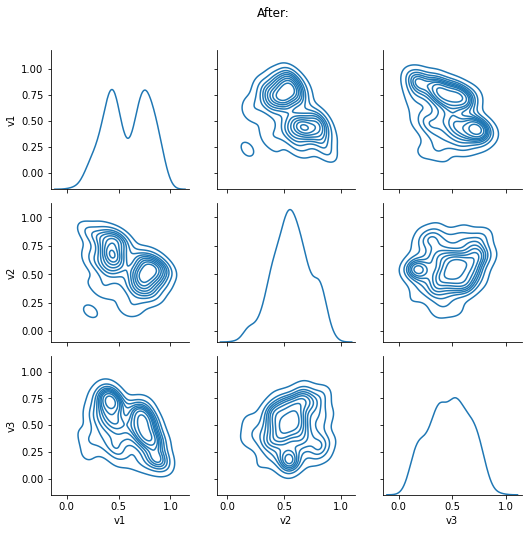

In [23]:
g = sns.PairGrid(pd.DataFrame(X_train_transformed, columns=column_names).iloc[:,:3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('After:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);

We can tell the data is slightly more **uniform and proportionally distributed**. <br>
The ranges were also shrunk to fit **between 0 and 1**.

## Training the auto-encoder

### Architecture of our model
Keras has become the standard high-level API within Tensorflow. 



In [24]:

# data dimensions // hyperparameters 
input_dim = X_train_transformed.shape[1]
latent_dim = 2
BATCH_SIZE = 256
EPOCHS = 30

# https://keras.io/layers/core/
autoencoder = tf.keras.models.Sequential([
    
    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )), 
    
    # adding some noise to the input data should help it generalize better
    tf.keras.layers.GaussianNoise(0.05),
    
    # compressed representation
    tf.keras.layers.Dense(latent_dim, activation='elu'),
    
    # reconstruction / decode
    tf.keras.layers.Dense(input_dim, activation='elu')
    
])

# https://keras.io/optimizers/
autoencoder.compile(optimizer='adam', 
                    loss='mse',
                    metrics=['acc'])

# print an overview of our model
autoencoder.summary();

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 29)                870       
_________________________________________________________________
gaussian_noise (GaussianNois (None, 29)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 60        
_________________________________________________________________
dense_2 (Dense)              (None, 29)                87        
Total params: 1,017
Trainable params: 1,017
Non-trainable params: 0
_________________________________________________________________


### Callbacks
Continue as long as the model is reducing the training loss.
Save only the weights for the model with the lowest validation loss, though.
Get graphical insights with Tensorboard.

In [25]:
from datetime import datetime

# current date and time
yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')

# new folder for a new run
log_subdir = f'{yyyymmddHHMM}_batch{BATCH_SIZE}_layers{len(autoencoder.layers)}'

# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0.00005,
    patience=3,
    verbose=1, 
    mode='min',
    restore_best_weights=False
)

save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoencoder_best_weights.hdf5',
    save_best_only=True,
    monitor='val_loss',
    verbose=0,
    mode='min'
)

tensorboard = tf.keras.callbacks.TensorBoard(
    f'logs/{log_subdir}',
    batch_size=BATCH_SIZE,
    update_freq='batch'
)

# callbacks argument only takes a list
cb = [early_stop, save_model, tensorboard]

### Training

In [26]:
history = autoencoder.fit(
    X_train_transformed, X_train_transformed,
    epochs=EPOCHS,
    callbacks=cb,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(X_validate_transformed, X_validate_transformed)
);

Epoch 1/30
625/625 [==============================] - 5s 8ms/step - loss: 0.0691 - acc: 0.1790 - val_loss: 0.0171 - val_acc: 0.2512
Epoch 2/30
625/625 [==============================] - 5s 8ms/step - loss: 0.0169 - acc: 0.2528 - val_loss: 0.0164 - val_acc: 0.2509
Epoch 3/30
625/625 [==============================] - 5s 7ms/step - loss: 0.0161 - acc: 0.2480 - val_loss: 0.0157 - val_acc: 0.2496
Epoch 4/30
625/625 [==============================] - 4s 7ms/step - loss: 0.0155 - acc: 0.2670 - val_loss: 0.0151 - val_acc: 0.2867
Epoch 5/30
625/625 [==============================] - 4s 7ms/step - loss: 0.0149 - acc: 0.3030 - val_loss: 0.0146 - val_acc: 0.3106
Epoch 6/30
625/625 [==============================] - 4s 7ms/step - loss: 0.0146 - acc: 0.3067 - val_loss: 0.0144 - val_acc: 0.3020
Epoch 7/30
625/625 [==============================] - 4s 7ms/step - loss: 0.0144 - acc: 0.3062 - val_loss: 0.0143 - val_acc: 0.3139
Epoch 8/30
625/625 [==============================] - 4s 7ms/step - loss: 0.

### Reconstructions
We apply the transformation pipeline to our test set.
Then, we pass the data through the trained autoencoder.



In [27]:
# transform the test set with the pipeline fitted to the training set
X_test_transformed = pipeline.transform(X_test)

# pass the transformed test set through the autoencoder to get the reconstructed result
reconstructions = autoencoder.predict(X_test_transformed)

#### Calculate the reconstruction loss for every transaction and draw a sample.

In [28]:
# calculating the mean squared error reconstruction loss per row in the numpy array
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)
# set to whatever you like
sample_size = 30

In [29]:
# showing the reconstruction losses for a subsample of transactions
print(f'Mean Squared Error reconstruction losses for {sample_size} clean transactions:')
print(mse[np.where(y_test==0)][:sample_size])
print(f'\nMean Squared Error reconstruction losses for {sample_size} fraudulent transactions:')
print(mse[np.where(y_test==1)][:sample_size])

Mean Squared Error reconstruction losses for 30 clean transactions:
[1.20938625 0.51398503 0.34779125 0.587631   0.67236201 1.45518172
 2.21444383 1.03691419 0.44568971 0.55347456 0.88630936 1.67483384
 1.55333963 1.09688613 0.60954693 1.24602725 0.66752321 0.97545035
 0.73109314 0.99751969 0.73350562 2.29446767 0.69369012 1.8154359
 1.99846723 0.87236965 0.72923833 8.16038067 0.55723455 9.71158112]

Mean Squared Error reconstruction losses for 30 fraudulent transactions:
[ 4.76825768 10.04606386 68.84973355  4.84813773  5.51802195  9.87249556
 76.91276847 24.00392492  6.01740985  2.45476096  6.60592627 24.44699027
  1.99018285  6.23844021 19.11566168 16.06034012  5.96175275 10.87506516
  5.53040702  7.28400412 13.4217709   2.03607114 12.88282496  2.37170775
  0.71068163  3.69538818  1.58260785  5.65837996 78.82929149 99.55214902]


Very promising! Although some transactions seem to fool the autoencoder, the fraudulent transactions clearly have a distinguishing element in their data that sets them apart from clean ones.

### Setting a threshold for classification
### Unsupervised
Normally, in an unsupervised solution, this is where the story would end. We would set a threshold that limits the amount of false positives to a manageable degree, and captures the most anomalous data points.

#### Percentiles
We could set this threshold by taking the top x% of the dataset and considering it anomalous.

#### MAD
We could also use a modified Z-score using the Median Absolute Deviation to define outliers on our reconstruction data. Here is a good blog post on the topic by João Rodrigues, illustrating why this algorithm is more robust and scalable than the percentiles method.

In [30]:
# modified version of: www.stackoverflow.com/questions/22354094/pythonic-way-of-detecting-outliers-in-one-dimensional-observation-data
def detect_mad_outliers(points, threshold=3.5):  
    
    # calculate the median of the input array
    median = np.median(points, axis=0)
    
    # calculate the absolute difference of each data point to the calculated median
    deviation = np.abs(points - median)
    
    # take the median of those absolute differences
    med_abs_deviation = np.median(deviation)
    
    # 0.6745 is the 0.75th quartile of the standard normal distribution,
    # to which the MAD converges.
    modified_z_score = 0.6745 * deviation / med_abs_deviation
    
    # return as extra information what the original mse value was at which the threshold is hit
    # need to find a way to compute this mathematically, but I'll just use the index of the nearest candidate for now
    idx = (np.abs(modified_z_score - threshold)).argmin()
    threshold_value = points[idx]

    return modified_z_score, threshold_value

# adjust this parameter to customise the recall/precision trade-off
Z_SCORE_THRESHOLD = 3

# find the outliers on our reconstructions' mean squared errors
mad_z_scores, threshold_value = detect_mad_outliers(mse, threshold=Z_SCORE_THRESHOLD)
mad_outliers = (mad_z_scores > Z_SCORE_THRESHOLD).astype(int)

In [31]:
anomalies = len(mad_outliers[mad_outliers==True])
total_trades = len(y_test)

print(f"""MAD Z-score > {Z_SCORE_THRESHOLD} is the selected threshold.
I.e. any trade with a mean squared reconstruction error >= {threshold_value:,.2f} is flagged.

This results in {anomalies:,} detected anomalies, or {anomalies/total_trades*100:.2f}% out of {total_trades:,} 
trades reported.""")

MAD Z-score > 3 is the selected threshold.
I.e. any trade with a mean squared reconstruction error >= 2.21 is flagged.

This results in 5,500 detected anomalies, or 6.49% out of 84,807 
trades reported.


### Semi-Supervised
However, us still having access to the labels means we can assess our model's performance more in-depth and fine tune it.

### Visualising the Anomaly Classification
We can plot the mean squared errors against the selected threshold to get an idea of how successful our method is. Note that we take the log10 of the mse, to help visualisation.

C:\Users\GregFlo\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


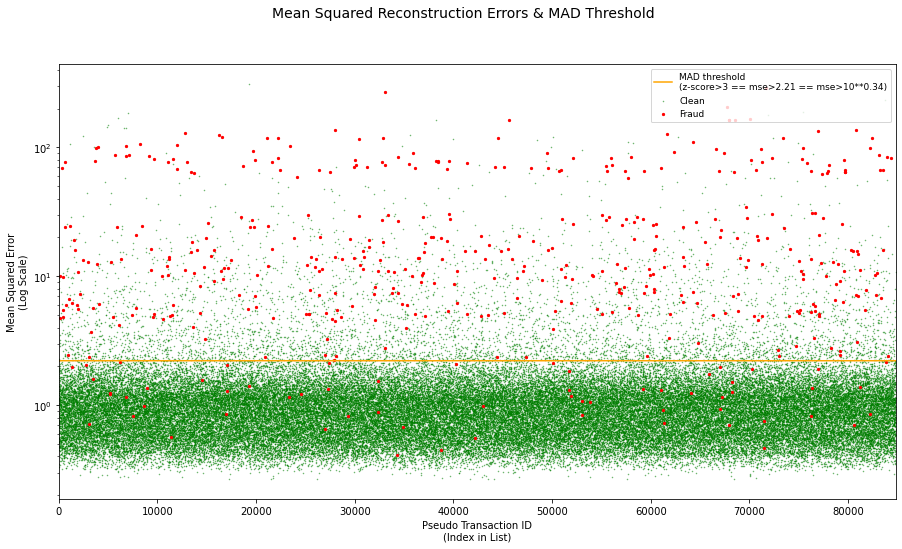

In [32]:
# so we can plot separately and thus customise for each class 
# (we have to retain the index number as the pseudo transaction id)
data = np.column_stack((range(len(mse)), mse))

# scatter's x & y
clean_x, clean_y = data[y_test==0][:,0], data[y_test==0][:,1]
fraud_x, fraud_y = data[y_test==1][:,0], data[y_test==1][:,1]

# instantiate new figure
fig, ax = plt.subplots(figsize=(15,8))

# plot reconstruction errors
ax.scatter(clean_x, clean_y, s=0.25, color='g', alpha=0.6, label='Clean')
ax.scatter(fraud_x, fraud_y, s=5.00, color='r', alpha=1,   label='Fraud')

# MAD threshold line
ax.plot([threshold_value for i in range(len(mse))], color='orange', linewidth=1.5, 
        label=f'MAD threshold\n(z-score>{Z_SCORE_THRESHOLD} == mse>{threshold_value:.2f} == mse>10**{np.log10(threshold_value):.2f})')

# change scale to log & limit x-axis range
ax.set_yscale('log')
ax.set_xlim(0, len(mse))

# title & labels
fig.suptitle('Mean Squared Reconstruction Errors & MAD Threshold', fontsize=14)
ax.set_xlabel('Pseudo Transaction ID\n(Index in List)')
ax.set_ylabel('Mean Squared Error\n(Log Scale)')

# orange legend for threshold value
ax.legend(loc='upper right', prop={'size': 9})

# display
fig.show();

### Classification Matrix on MAD outliers
A closer look:

In [33]:
from sklearn.metrics import confusion_matrix

# get (mis)classification
cm = confusion_matrix(y_test, mad_outliers)

In [34]:
print(f'The classifications using the MAD method with threshold={Z_SCORE_THRESHOLD} are as follows:\n{cm}\n')
print(f'Fraud caught successfully (recall):\n{cm[1,1]} / ({cm[1,0]} + {cm[1,1]}) = {cm[1,1] / (cm[1,0] + cm[1,1]) * 100:.2f}%')

The classifications using the MAD method with threshold=3 are as follows:
[[79247  5068]
 [   60   432]]

Fraud caught successfully (recall):
432 / (60 + 432) = 87.80%


#### Asymmetric error cost
In the real world, we can expect different costs associated with reporting a false positive versus reporting a false negative. Missing a fraud case is likely to be much more costly than wrongly flagging a transaction as one. In another kernel, I discuss an approach to determining these costs for this dataset in depth.

#### Recall & Precision
Generally speaking, you will have to prioritise what you find more important. This dilemma is commonly called the "recall vs precision" trade-off. If you want to increase recall, adjust the MAD's Z-Score threshold downwards, if you want recover precision, increase it.

### Latent Space
It is always interesting to look at the compressed representation our neural network devised.

### Encoder
Let's build the encoder that gets us to the bottleneck. We take the layers from our autoencoder.


In [35]:
encoder = tf.keras.models.Sequential([
    autoencoder.layers[0],
    autoencoder.layers[1],
    autoencoder.layers[2]
])

### Undersampling
Consistent with the previous t-sne visualisation, let's undersample the clean transactions.

In [36]:
# taking all the fraud, undersampling clean
fraud = X_test_transformed[y_test==1]
clean = X_test_transformed[y_test==0][:len(fraud) * RATIO_TO_FRAUD, ]

# combining arrays & building labels
features = np.append(fraud, clean, axis=0)
labels = np.append(np.ones(len(fraud)),
                   np.zeros(len(clean)))

# getting latent space representation
latent_representation = encoder.predict(features)

print(f'Clean transactions downsampled from {len(X_test_transformed[y_test==0]):,} to {len(clean):,}.')
print('Shape of latent representation:', latent_representation.shape)

Clean transactions downsampled from 84,315 to 4,920.
Shape of latent representation: (5412, 2)


### Visualising the Latent Space


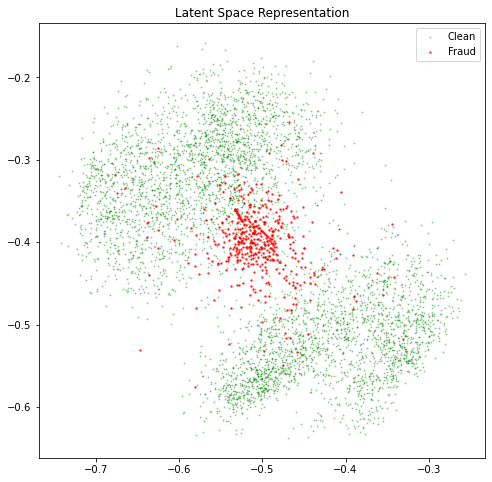

In [37]:
X = latent_representation[:,0]
y = latent_representation[:,1]

# plotting
plt.subplots(figsize=(8, 8))
plt.scatter(X[labels==0], y[labels==0], s=1, c='g', alpha=0.3, label='Clean')
plt.scatter(X[labels==1], y[labels==1], s=2, c='r', alpha=0.7, label='Fraud')

# labeling
plt.legend(loc='best')
plt.title('Latent Space Representation')

# saving & displaying
plt.savefig('latent_representation_2d');
plt.show()

Although there is no perfectly distinct cluster, most of the fradulent transactions appear to be neatly grouped together(a few are still hiding amongst non-fraudulent transactions). This is in line with the hope/idea that both classes would occupy distinct areas in latent space, due to the encoder's weights not being calibrated to cope with fraudulent transactions.

# Conclusion
We could already tell from our misclassifications that the network was not able to generalize perfectly. However, we must not forget that **our model was trained never having seen a single fraud case!** In that regard, its performance is decent. It illustrates the power of **autoencoders as anomaly detection tools**.

To improve its performance, perhaps we need to:
* improve the model architecture
* diversify the training data more, with a broader sample of clean transactions
* augment the data with different, additional features - the data itself might not be good enough to distinguish between classes perfectly (i.e. fraudsters are disguising themselves well enough to always go undetected using these data points, no matter the algorithm).